# Feature display.
---

This technique not only allows us to create an interesting filter for our images, and to know which are the patterns learned by the network. Also, used correctly, it would allow us to obtain **what are the patterns learned by each of the network filters.** This is known as Feature Visualization.

As explained in the following article, to achieve this, we will not have to excite all the ***feature maps*** of a specific layer, but only one of them (the one of the filter that we are interested in visualizing).

<br>
<img src='https://i.imgur.com/lMR9UAU.png'>
<br>

For it:

- We create a random noise image that we will use as input image, with size 256x256x3, with values that vary from 0-255

> **LINK:**💡 https://distill.pub/2017/feature-visualization/

📸 Example of the result that we will obtain:

<img width=300px src='https://i.imgur.com/Xto5LVj.png'>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl

import IPython.display as display
import PIL.Image
import random

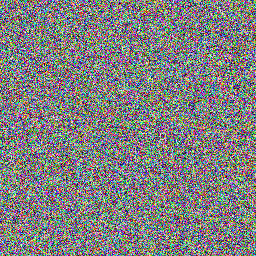

In [ ]:
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


original_img = np.zeros((256,256,3),np.uint8)

for x in range(256):
    for y in range(256):
        original_img[x,y] = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]

show(original_img)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Now, we load a pre-trained model like InceptionV3 or VGG.
base_model = InceptionV3(include_top=False, weights='imagenet')

# We can visualize the architecture of the loaded network.
for i, layer in enumerate(base_model.layers):
  print('Layer ' + str(i) + ':', layer.name)

87910968/87910968 [==============================] - 1s 0us/step
Layer 0: input_1
Layer 1: conv2d
Layer 2: batch_normalization
Layer 3: activation
Layer 4: conv2d_1
Layer 5: batch_normalization_1
Layer 6: activation_1
Layer 7: conv2d_2
Layer 8: batch_normalization_2
Layer 9: activation_2
Layer 10: max_pooling2d
Layer 11: conv2d_3
Layer 12: batch_normalization_3
Layer 13: activation_3
Layer 14: conv2d_4
Layer 15: batch_normalization_4
Layer 16: activation_4
Layer 17: max_pooling2d_1
Layer 18: conv2d_8
Layer 19: batch_normalization_8
Layer 20: activation_8
Layer 21: conv2d_6
Layer 22: conv2d_9
Layer 23: batch_normalization_6
Layer 24: batch_normalization_9
Layer 25: activation_6
Layer 26: activation_9
Layer 27: average_pooling2d
Layer 28: conv2d_5
Layer 29: conv2d_7
Layer 30: conv2d_10
Layer 31: conv2d_11
Layer 32: batch_normalization_5
Layer 33: batch_normalization_7
Layer 34: batch_normalization_10
Layer 35: batch_normalization_11
Layer 36: activation_5
Layer 37: activation_7
Layer 38:

In [ ]:
# We choose which layers we want to obtain the activations to maximize.
layers = [base_model.get_layer(name).output for name in ['mixed5']]

# We create a model that will have output points on the chosen layers.
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [ ]:
def calc_loss(img, model):
  
  # Add the batch dimension to the image.
  # [256, 256, 3] -> [1, 256, 256, 3]
  img_batch = tf.expand_dims(img, axis=0)

  # Give the image as input to the model
  # and get the feature maps.
  layer_activations = model(img_batch)

  # For all feature maps in each layer,
  # we will calculate what is the average of their activations
  # and we will add them all to calculate the value
  # to optimize, which we will store in loss.
  losses = []

  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  for act in layer_activations:
    # We select all the feature maps.
    loss = tf.math.reduce_mean(act[:,:,:,0:1])
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [ ]:
import scipy

# We create a Tensorflow module to implement
# the logic of Deep Dream.
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  def __call__(self, img, steps, step_size):
      
      print("Calculando steps...")

      loss = tf.constant(0.0)
      
      # We create the 'training loop'
      for n in tf.range(steps):

        # And we record the necessary operations. In this
        # case, are the operations that connect to our
        # input image, with the 'loss' we want
        # optimize: in this case the activation of the f.maps.
        with tf.GradientTape() as tape:
          
          # We have to explicitly tell Tensorflow that
          # the pixels of our image are parameters to watch.
          tape.watch(img)
          # We use the method to calculate the activation of the layers selected.
          loss = calc_loss(img, self.model)

        # Calculate the gradient between pixels and activations.
        gradients = tape.gradient(loss, img)

        # We normalize the values of the gradient.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.

        # ----- We'll discuss this later ------ #       
        # img = scipy.ndimage.rotate(img, 0.2 * (np.random.rand() - 0.5), reshape=False)
        # img = scipy.ndimage.shift(img, [0.1 * (np.random.rand() - 0.5),
        #                                 0.1 * (np.random.rand() - 0.5), 0])
        # img = tf.convert_to_tensor(img)


        # And we perform the RISE of the gradient, that is, we add the gradient vector.
        img = img + gradients * step_size
        # We control that the pixels of the images remain in the range [-1, 1]
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

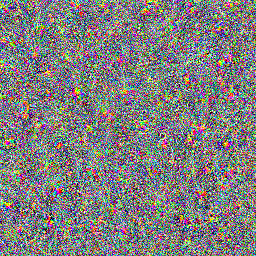

In [ ]:
deepdream = DeepDream(dream_model)

cycles    = 10
run_steps = 100
step_size = 0.001

img = original_img

# We preprocess the image with the necessary preprocessing.
img = tf.convert_to_tensor(preprocess_input(img))

# For each cycle...
for cycle in range(cycles):
  
  # We call the Deep Dream model and execute a few steps.
  loss, img = deepdream(img, run_steps, tf.constant(step_size))

  # Let's visualize the result.
  display.clear_output(wait=True)
  show(deprocess(img))
  print ("Ciclo {}, loss {}".format(cycle, loss))


result = deprocess(img)
display.clear_output(wait=True)
show(result)

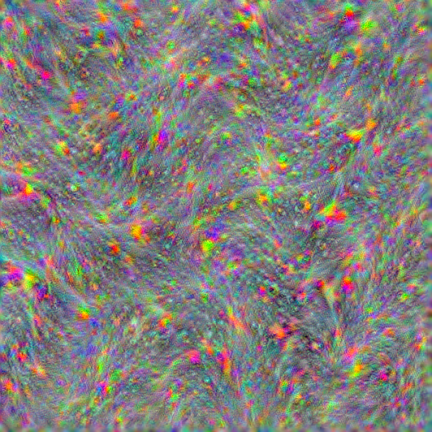

Ciclo 2, loss 11.481565475463867


In [ ]:
OCTAVE_SCALE = 1.30

deepdream = DeepDream(dream_model)

cycles    = 3
run_steps = 100
step_size = 0.001

img = original_img

# We preprocess the image with the necessary preprocessing.
img = tf.convert_to_tensor(preprocess_input(img))

# We save the original shape of the image.
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-3, 3):

  # Calculate the new shape of the image.
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
  # Y le cambiamos el tamaño.
  img = tf.image.resize(img, new_shape)

  # For each cycle...
  for cycle in range(cycles):
    
    # We call the Deep Dream model and execute a few steps.
    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    # Let's visualize the result.
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Ciclo {}, loss {}".format(cycle, loss))